In [1]:
import sympy as sp
from math import*
import numpy as np
import control
from control import TransferFunction
from control.matlab import step , impulse
import matplotlib
from scipy import optimize
import scipy.linalg 
from matplotlib import pylab, mlab
import matplotlib.pylab as pylab
import random

# forces plots to appear in the ipython notebook
%matplotlib inline

from scipy.integrate import odeint
from pylab import plot,xlabel,ylabel,title,legend,figure,subplots

from pylab import cos, pi, arange, sqrt, pi, array

from numpy import ma
import matplotlib.pyplot as plt

from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs
import IPython
import math
sp.init_printing()

In [2]:
#################################
# Simple optimization example
################################

import cvxpy as cp
import numpy as np

# Problem data.
m = 30
n = 20
np.random.seed(1)
A = np.random.randn(m, n)
b = np.random.randn(m)

# Construct the problem.
x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A*x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print(x.value)
# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
print(constraints[0].dual_value)


import scipy
scipy.__version__
def fun(x):
    return (x-1)**2

bounds = [(-2, 2)]
res = scipy.optimize.minimize(fun, x0 = [-1.5], bounds=bounds, jac='2-point', method = 'trust-constr')
res

[-1.00049723e-03  2.78867474e-02  1.72324009e-03  3.67299258e-05
 -1.34110728e-03  1.49849244e-01 -6.94547812e-04  4.95171402e-04
  2.46109612e-01  5.76052476e-01 -2.31429313e-03  2.33210221e-04
 -4.49099455e-04  2.25180894e-01 -9.46443449e-04 -4.96566507e-04
 -8.01071048e-04 -8.34661500e-04  7.72478759e-04 -2.09625000e-03]
[ 1.09903552 -1.02492371  2.26933624  0.95084789  4.0133446   0.68365192
  0.28785274  2.06516239  1.37049403 -2.56192713  0.28915791 -1.02321332
 -1.12096684  1.28940399  3.1629931   1.5340185  -1.031995    1.4154816
 -0.90756085  0.30574722]


 barrier_parameter: 3.200000000000001e-05
 barrier_tolerance: 3.200000000000001e-05
          cg_niter: 7
      cg_stop_cond: 1
            constr: [array([0.99998933])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 0.10673213005065918
               fun: array([1.13950466e-10])
              grad: array([-2.13346156e-05])
               jac: [<1x1 sparse matrix of type '<type 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([-7.87159923e-10])
           message: '`gtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 16
              nhev: 0
             niter: 13
              njev: 0
        optimality: 7.871599226761262e-10
            status: 1
         tr_radius: 44972.35047482108
                 v: [array([2.13338284e-05])]
                 x: array([0.99998933])

In [3]:
class ABAG:
    def __init__(abag, delta_gain, delta_bias, min_gain, alpha, e_b, e_g, reverse_error, area_error):
        abag.delta_gain = delta_gain
        abag.delta_bias = delta_bias
        abag.min_gain = min_gain
        abag.alpha = alpha
        abag.e_b = e_b
        abag.e_g = e_g
        abag.gain = 0.0
        abag.bias = 0.0
        abag.e_bar = 0.0
        abag.reverse_error = reverse_error
        abag.area_error = area_error
        
    def control(abag, y_m, y_d, area_size):
        if abag.area_error:
            difference = np.absolute(y_d - y_m)
            if difference <= area_size:
                y_m = y_d
                
        if not abag.reverse_error:
            if (y_m < y_d): 
                abag.e_bar = abag.alpha * abag.e_bar + (1.0 - abag.alpha)
            else: 
                abag.e_bar = abag.alpha * abag.e_bar - (1.0 - abag.alpha)
        else:
            if (y_m > y_d): 
                abag.e_bar = abag.alpha * abag.e_bar + (1.0 - abag.alpha)
            else: 
                abag.e_bar = abag.alpha * abag.e_bar - (1.0 - abag.alpha)
    
        abag.bias = abag.saturate((abag.bias + abag.delta_bias * abag.xi_bias(abag.e_bar)), -1.0)
        abag.gain = abag.saturate((abag.gain + abag.delta_gain * abag.xi_gain(abag.e_bar)), 0.0)

        u = 0.0
        if not abag.reverse_error:
            if (y_m < y_d): 
                u = abag.saturate((abag.bias + abag.gain), -1.0)
            else:
                u = abag.saturate((abag.bias - abag.gain), -1.0)
        else:
            if (y_m > y_d): 
                u = abag.saturate((abag.bias + abag.gain), -1.0)
            else:
                u = abag.saturate((abag.bias - abag.gain), -1.0)

        return u


    def saturate(abag, value, lower_limit):
        if (value < lower_limit):
            return 0.0
        elif (value > 1.0):
            return 1.0
        else:
            return value
        
    def xi_bias(abag, e_bar):
        if (e_bar < -abag.e_b): 
            return -1.0
        elif (e_bar > abag.e_b): 
            return 1.0
        else: 
            return 0.0
        
    def xi_gain(abag, e_bar):
        if (e_bar < -abag.e_g):
            return 1.0
        elif (e_bar > abag.e_g):
            return 1.0
        else:
            return -1.0     

In [4]:
class Plant:
    def __init__(plant, damping, mass, gravity):
        plant.damping = damping
        plant.mass = mass
        plant.gravity = gravity
        
    def massDamper(plant, state, t, u, m, c):
        '''
        k = spring constant
        m = mass
        c = damping coefficient

        for a mass,spring
            xdd = (-k*x)/m + g
        for a mass, spring, damper 
            xdd = -k*x/m - c*xd/m - g
        for a mass, spring, damper with forcing function
            xdd = -(k*x)/m - (c*xd)/m - g + f/m
        '''

        '''
        for a mass, damper, no gravity with forcing function
            xdd = (-c*xd)/m + u/m
        '''

        # state vector
        x, xd = state # displacement x and velocity x'

        # compute acceleration xdd = x''
        xdd = u/m - c*xd/m
        
        return [xd, xdd]
    
    def massGravity(plant, state, t, u, m, g):
        '''
            Point mass falling or rising w.t.r. ground. 
            Forces influencing: * external force pushing upwards
                                * gravity pushing downwards.
        '''

        # state vector
        x, xd = state # displacement x and velocity x'

        # compute acceleration xdd = x''
        xdd = u/m - g
        return [xd, xdd]
    
    def simulate_MG(plant, u, state, time_step):
        '''
        Integrate/simulate only for one step.
        Maybe we should integrate for more than one step? 
        In that case, the ABAG controller would not run at same frequency as change/update of dynamics occur? 
        '''
        state0 = state  #initial conditions [x0 , v0] 
        t0 = 0.0  # initial time
        tf = time_step * 2 # final time
        t = arange(t0, tf, step)
        new_state = odeint(plant.massGravity, state0, t, args = (u, plant.mass, plant.gravity), printmessg = True)
        x = new_state[:, [0]]
        xd = new_state[:, [1]]
        new_state = np.squeeze(np.array([x[-1], xd[-1]])) 
        return new_state
    
    def simulate_MD(plant, u, state, noise_level, time_step):
        '''
        Integrate/simulate only for one step.
        '''
        state0 = state  #initial conditions [x0 , v0] 
        t0 = 0.0  # initial time
        noise =  np.random.standard_normal(1)
        step = time_step  # step
        tf = step * 2 # final time
        t = arange(t0, tf, step)
        new_state = odeint(plant.massDamper, state0, t, args = (u, plant.mass, plant.damping), printmessg = True)
        x = new_state[:, [0]] + noise_level * noise
        xd = new_state[:, [1]] + noise_level * noise
        new_state = np.squeeze(np.array([x[-1], xd[-1]])) 
        return new_state
    
    def simulate_generic(plant, u, state, noise_level):
        
        x, y_m = state
        noise =  np.random.standard_normal(1)
        y_dot = plant.damping - plant.mass * u 
        y_m = y_m + y_dot + noise_level * noise
        return [x, y_m]    
    
    

# Code taken from: http://www.coldvision.io/2017/08/04/model-predictive-control-cars-c/ 
class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0
 
    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)
 
    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise
 
    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift
 
    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0
 
        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)
 
        # apply steering drift
        steering2 += self.steering_drift
 
        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length
 
        if np.absolute(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)
 
    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

Elements of step function: [50.         45.19686487 45.31994352 50.24300347 54.91683307]


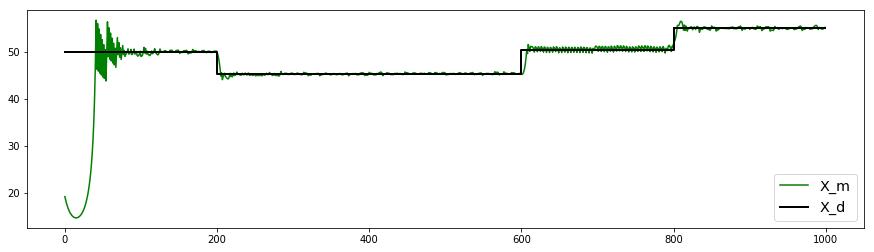

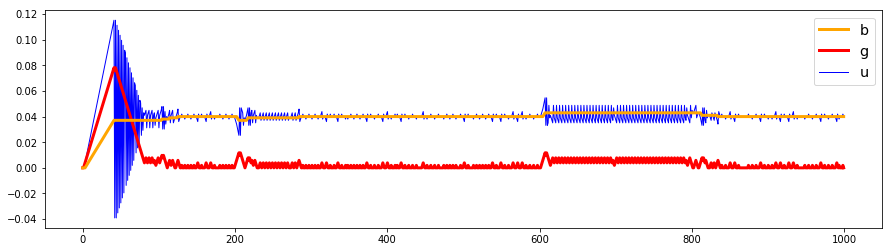

In [5]:
#########################################################################
# Tesing code for Generic plant -> Setpoint with noise!
#########################################################################

x = 20.0 #initial freq 20Hz
y_m = 1/x

max_iteration = 1000
step_change = 200
noise_level = 0.00002
samples = np.arange(0, max_iteration, step_change)
y0 = np.sin(samples)
x_d = y0.copy() * 5.5 + 50
num_samples = np.size(x_d)

print("Elements of step function: " + str(x_d))

abag = ABAG(delta_gain = 0.001953, 
            delta_bias = 0.000976, 
            min_gain = 0.000976, 
            alpha = 0.75, 
            e_b = 0.75, 
            e_g = 0.5,
            reverse_error = True,
            area_error = True)

plant = Plant(damping = 0.002, mass = 0.05, gravity = 9.81)

measurements = []
bias = []
gain = []
command = []
state = [0.0, y_m]

for n in range(num_samples):
    y_d = 1/x_d[n]
    for i in range(step_change):
        u = abag.control(state[1], y_d, 0.0)
        bias.append(abag.bias)
        gain.append(abag.gain)
        command.append(u)
        state = plant.simulate_generic(u, state, noise_level)
        measurements.append(1/state[1])

plt.figure(figsize = (15,4))
plt.plot(np.array(measurements), c = 'green', label='X_m', zorder=1)

if not num_samples == 1:
    plt.step(samples, x_d, label='X_d', linewidth = 2, where='post', color = 'black')
    l = plt.hlines(xmin = 800, xmax = 1000, y = x_d[-1], color = 'black', linewidth=2, zorder=2)
else:
    l = plt.axhline(y = x_d[0], label='X_d', c = 'black', linewidth=2)
    
plt.legend(loc=4, fontsize = 'x-large')
plt.show()

plt.figure(figsize = (15,4))
plt.plot(np.array(bias), c = 'orange', label='b', linewidth=3, zorder=3)
plt.plot(np.array(gain), c = 'red', label='g', linewidth=3, zorder=2)
plt.plot(np.array(command), c = 'blue', label='u', linewidth=1, zorder=1)
plt.legend(loc=1, fontsize = 'x-large')
plt.show()

Elements of step function: [50.0]


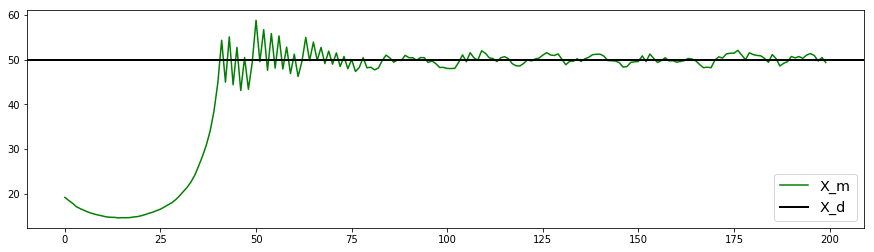

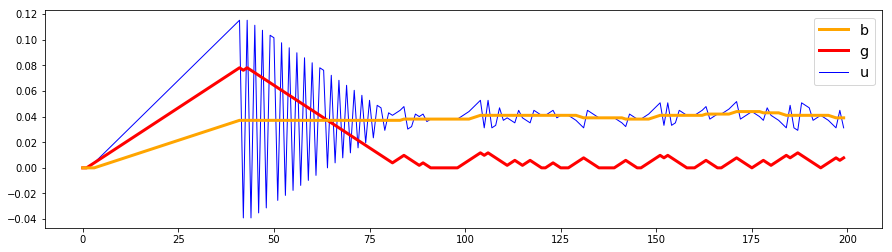

In [6]:
#########################################################################
# Tesing code for Generic plant with area error instead of setpoint!
# Noise in plant included!
# IF ABAG is not tuned properly, it can be confused with area error...
# try with 0.01 and see
#########################################################################

x = 20.0 #initial freq 20Hz
y_m = 1/x
max_iteration = 200
step_change = 200
noise_level = 0.0002

x_d = [50.0]
area_size = 0.0

# area_size = 0.001
num_samples = 1

print("Elements of step function: " + str(x_d))

abag = ABAG(delta_gain = 0.001953, 
            delta_bias = 0.000976, 
            min_gain = 0.000976, 
            alpha = 0.75, 
            e_b = 0.75, 
            e_g = 0.5,
            reverse_error = True,
            area_error = True)

plant = Plant(damping = 0.002, mass = 0.05, gravity = 9.81)

measurements = []
bias = []
gain = []
command = []
state = [0.0, y_m]

for n in range(num_samples):
    y_d = 1/x_d[n]
    for i in range(step_change):
        u = abag.control(state[1], y_d, area_size)
        bias.append(abag.bias)
        gain.append(abag.gain)
        command.append(u)
        state = plant.simulate_generic(u, state, noise_level)
        measurements.append(1/state[1])

plt.figure(figsize = (15,4))
plt.plot(np.array(measurements), c = 'green', label='X_m', zorder=1)

if not num_samples == 1:
    plt.step(samples, x_d, label='X_d', linewidth = 2, where='post', color = 'black')
    l = plt.hlines(xmin = 800, xmax = 1000, y = x_d[-1], color = 'black', linewidth=2, zorder=2)
else:
    l = plt.axhline(y = x_d[0], label='X_d', c = 'black', linewidth=2)
    
plt.legend(loc=4, fontsize = 'x-large')
plt.show()

plt.figure(figsize = (15,4))
plt.plot(np.array(bias), c = 'orange', label='b', linewidth=3, zorder=3)
plt.plot(np.array(gain), c = 'red', label='g', linewidth=3, zorder=2)
plt.plot(np.array(command), c = 'blue', label='u', linewidth=1, zorder=1)
plt.legend(loc=1, fontsize = 'x-large')
plt.show()

Elements of step function: [50.         45.19686487 45.31994352 50.24300347 54.91683307]


/home/djole/.local/lib/python2.7/site-packages/scipy-1.2.0.dev0+6683b5f-py2.7-linux-x86_64.egg/scipy/integrate/odepack.py:250: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)


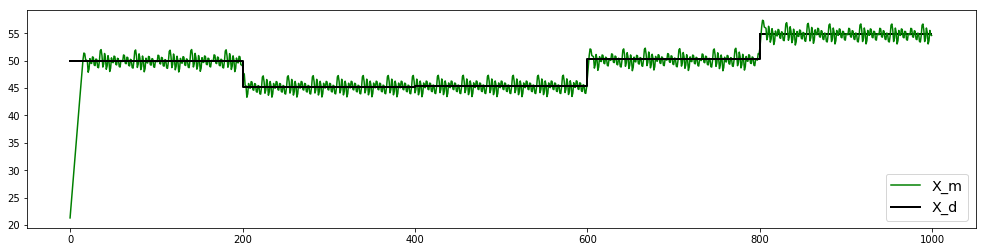

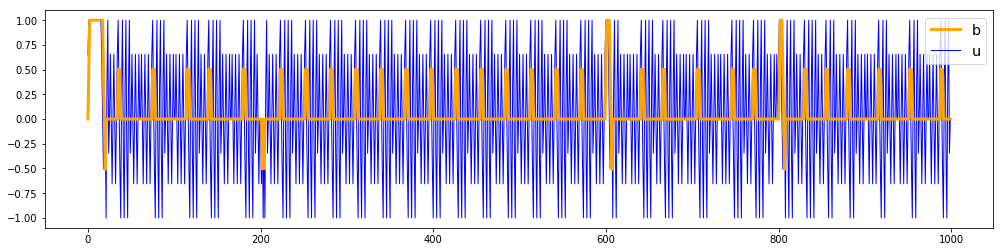

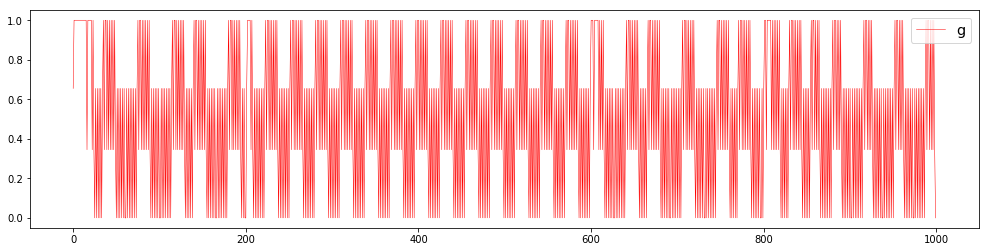

In [7]:
#########################################################################
# Tesing code for Mass-Damper plant -> Area error instead of Setpoint
# Noise included in plant!
#########################################################################

x_m = 20.0 #initial frequency Hz

max_iteration = 1000
step_change = 200
area_size = 0.0
noise_level = 0.002
samples = np.arange(0, max_iteration, step_change)
y0 = np.sin(samples)
x_d = y0.copy() * 5.5 + 50
num_samples = np.size(x_d)
delta_time = 0.001

print("Elements of step function: " + str(x_d))

abag = ABAG(delta_gain = 0.65515291, 
            delta_bias = 0.50349577, 
            min_gain = 0.000976, 
            alpha =  0.47800105, 
            e_b = 0.72427752, 
            e_g =  0.43249228,
            reverse_error = False,
            area_error = True)

plant = Plant(damping = 0.01, mass = 0.005, gravity = 9.81)

measurements = []
bias = []
gain = []
command = []
state = [0.0, x_m]

for n in range(num_samples):
    for i in range(step_change):
        u = abag.control(state[1], x_d[n], area_size)
        bias.append(abag.bias)
        gain.append(abag.gain)
        command.append(u)
        state = plant.simulate_MD(u * 10, state, noise_level, delta_time)
        measurements.append(state[1])

plt.figure(figsize = (17,4))
plt.plot(np.array(measurements), c = 'green', label='X_m', zorder=2)

if not num_samples == 1:
    plt.step(samples, x_d, label='X_d', linewidth = 2, where='post', color = 'black')
    l = plt.hlines(xmin = 800, xmax = 1000, y = x_d[-1], color = 'black',linewidth=2, zorder=1)
else:
    l = plt.axhline(y = x_d[0], label='X_d', c = 'black', linewidth=2)
    
plt.legend(loc=4, fontsize = 'x-large')
plt.show()

plt.figure(figsize = (17,4))
plt.plot(np.array(bias), c = 'orange', label='b', linewidth=3, zorder=3)
plt.plot(np.array(command), c = 'blue', label='u', linewidth=1, zorder=2)
plt.legend(loc=1, fontsize = 'x-large')
plt.show()

plt.figure(figsize = (17,4))
plt.plot(np.array(gain), c = 'red', label='g', linewidth=0.5, zorder=1)
plt.legend(loc=1, fontsize = 'x-large')
plt.show()

In [8]:
#############################################################################################################
# MPC controller! for mass damper system
# Question is if we need to include noise in the model that is used for predictions, or to go without noise!
# For now model for prediction will be without the noise!
##############################################################################################################

class MPC:
    #Initialisation
    def __init__(mpc, position, velocity, plant):
        mpc.position = position
        mpc.velocity = velocity
        mpc.plant = plant
    
    def predict(mpc, abag_params, step_change, trajectory, delta_time, area_size, noise_level):        
        state = [mpc.position, mpc.velocity]
        mpc.abag = ABAG(delta_gain = abag_params[0], 
                        delta_bias = abag_params[1], 
                        min_gain = 0.000976, 
                        alpha = abag_params[2], 
                        e_b = abag_params[3], 
                        e_g = abag_params[4],
                        reverse_error = False,
                        area_error = True)
        final_error = 0
        num_samples = np.size(trajectory)
        for n in range(num_samples):
            for i in range(step_change):
                final_error = final_error + (trajectory[n] - state[1])**2
                u = abag.control(state[1], trajectory[n], area_size)
                if abag.gain > 0.9:
                    final_error = final_error + 10000
                state = mpc.plant.simulate_MD(u * 10, state, noise_level, delta_time)
                
        return final_error

    def control(mpc, y_m, y_d, area_size):
        pass
    
    def optimizer(mpc, init_params, cons, step_change, trajectory, delta_time, area_size, noise_level, opti_method):
        if opti_method is 'trust-constr':
            result = optimize.minimize(mpc.predict, init_params, 
                                       args=(step_change, trajectory, delta_time, area_size, noise_level), 
                                       method='trust-constr', jac= '3-point', constraints=cons, options={'disp': True})
        else:
            result = optimize.minimize(mpc.predict, init_params, 
                                       args=(step_change, trajectory, delta_time, area_size, noise_level), 
                                       method = opti_method, constraints=cons, options={'disp': True})
        print(result.message)
        return result.x

In [11]:
#########################################################################
# Tesing code for Mass-Damper plant -> MPC controller
#########################################################################

initial_velocity = 20.0 #initial frequency Hz
bounds = (0.000001, 0.999999)

init_parameters = [0.65515291, 0.50349577, 0.47800105, 0.72427752, 0.43249228]

#construct the bounds in the form of constraints
constraints = []
for factor in range(len(init_parameters)):
    lower, upper = bounds
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper, i=factor: ub - x[i]}
    constraints.append(l)
    constraints.append(u)

max_iteration = 1000
step_change = 200
area_size = 0.0
noise_level = 0.0

samples = np.arange(0, max_iteration, step_change)
y0 = np.sin(samples)
desired_trajectory = y0.copy() * 5.5 + 50
x_d = desired_trajectory
delta_time = 0.001 
opti_method  = 'trust-constr'
print("Elements of step function: " + str(x_d))
num_samples = np.size(x_d)

plant = Plant(damping = 0.01, mass = 0.005, gravity = 9.81)
mpc = MPC (0.0, initial_velocity, plant)
optimized_parameters = mpc.optimizer(init_parameters, constraints, 
                                     step_change, desired_trajectory, 
                                     delta_time, area_size, noise_level, opti_method)
print("Result: ")
print(optimized_parameters)

noise_level = 0.000
abag = ABAG(delta_gain = optimized_parameters[0], 
            delta_bias = optimized_parameters[1], 
            min_gain = 0.000976, 
            alpha = optimized_parameters[2], 
            e_b = optimized_parameters[3], 
            e_g = optimized_parameters[4],
            reverse_error = False,
            area_error = True)

measurements = []
bias = []
gain = []
command = []
state = [0.0, initial_velocity]

for n in range(num_samples):
    for i in range(step_change):
        u = abag.control(state[1], desired_trajectory[n], area_size)
        bias.append(abag.bias)
        gain.append(abag.gain)
        command.append(u)
        state = plant.simulate_MD(u * 10, state, noise_level, delta_time)
        measurements.append(state[1])

plt.figure(figsize = (17,4))
plt.plot(np.array(measurements), c = 'green', label='X_m', zorder=2)

if not num_samples == 1:
    plt.step(samples, x_d, label='X_d', linewidth = 2, where='post', color = 'black')
    l = plt.hlines(xmin = 800, xmax = 1000, y = x_d[-1], color = 'black',linewidth=2, zorder=1)
else:
    l = plt.axhline(y = x_d[0], label='X_d', c = 'black', linewidth=2)
    
plt.legend(loc=4, fontsize = 'x-large')
plt.show()

plt.figure(figsize = (17,4))
plt.plot(np.array(bias), c = 'orange', label='b', linewidth=3, zorder=3)
plt.plot(np.array(command), c = 'blue', label='u', linewidth=1, zorder=2)
plt.legend(loc=1, fontsize = 'x-large')
plt.show()

plt.figure(figsize = (17,4))
plt.plot(np.array(gain), c = 'red', label='g', linewidth=0.5, zorder=1)
plt.legend(loc=1, fontsize = 'x-large')
plt.show()

Elements of step function: [50.         45.19686487 45.31994352 50.24300347 54.91683307]


/home/djole/.local/lib/python2.7/site-packages/scipy-1.2.0.dev0+6683b5f-py2.7-linux-x86_64.egg/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


KeyboardInterrupt: 

In [130]:
#############################################################################################################
# MPC controller! for Mass-Gravity plant 
##############################################################################################################

class MPC_MG:

    def __init__(mpc, position, velocity, plant):
        mpc.position = position
        mpc.velocity = velocity
        mpc.plant = plant
    
    def predict(mpc, abag_params, step_change, trajectory, delta_time, area_size, noise_level, command_gain):        
        state = [mpc.position, mpc.velocity]
        mpc.abag = ABAG(delta_gain = abag_params[0], 
                        delta_bias = abag_params[1], 
                        min_gain = 0.000976, 
                        alpha = abag_params[2], 
                        e_b = abag_params[3], 
                        e_g = abag_params[4],
                        reverse_error = False,
                        area_error = True)
        final_error = 0
        num_samples = np.size(trajectory)
        for n in range(num_samples):
            for i in range(step_change):
                final_error = final_error + (trajectory[n] - state[0])**2
                u = abag.control(state[0], trajectory[n], area_size)
                if abag.gain > 0.9:
                    final_error = final_error + 0
                state = mpc.plant.simulate_MG(u * abag_params[5], state, delta_time)
                
        return final_error

    def control(mpc, y_m, y_d, area_size):
        pass
    
    def optimizer(mpc, init_params, cons, step_change, trajectory, delta_time, area_size, noise_level, command_gain, opti_method):
        if opti_method is 'trust-constr':
            result = optimize.minimize(mpc.predict, init_params, 
                                       args=(step_change, trajectory, delta_time, area_size, noise_level, command_gain), 
                                       method='trust-constr', jac= '3-point', constraints=cons, options={'disp': True})
        else:
            result = optimize.minimize(mpc.predict, init_params, 
                                       args=(step_change, trajectory, delta_time, area_size, noise_level, command_gain), 
                                       method = opti_method, constraints=cons, options={'disp': True})
        print(result.message)
        return result.x

In [143]:
#########################################################################
# Tesing code for Mass-Gravity plant -> Setpoint no noise!
#########################################################################

bounds = (0.000001, 0.999999)
init_parameters = [0.20494141, 0.01870464, 0.58973973, 0.01831093, 0.99648092, 3.54407116]

#construct the bounds in the form of constraints
constraints = []
for factor in range(len(init_parameters)-1):
    lower, upper = bounds
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper, i=factor: ub - x[i]}
    constraints.append(l)
    constraints.append(u)
l = {'type': 'ineq',
     'fun': lambda x, lb=0.0, i=factor: x[i] - lb}
constraints.append(l)

x_m = 52 #initial height [m]
max_iteration = 200
step_change = 200
area_size = 0.0
samples = np.arange(0, max_iteration, step_change)
y0 = np.sin(samples)
x_d = y0.copy() * 5.5 + 50
num_samples = np.size(x_d)
delta_time = 0.001 
opti_method  = 'trust-constr'
# opti_method  = 'COBYLA'
print("Elements of step function: " + str(x_d))
num_samples = np.size(x_d)

plant = Plant(damping = 0.01, mass = 0.005, gravity = 9.81)
mpc_mg = MPC_MG (x_m, 0.0, plant)
optimized_parameters = mpc_mg.optimizer(init_parameters, constraints, 
                                     step_change, x_d, delta_time, 
                                     area_size, noise_level, command_gain, opti_method)
print("Result: ")
print(optimized_parameters)
command_gain = optimized_parameters[5]
noise_level = 0.000

abag = ABAG(delta_gain = optimized_parameters[0], 
            delta_bias = optimized_parameters[1],  
            min_gain = 0.000976, 
            alpha = optimized_parameters[2],  
            e_b = optimized_parameters[3],  
            e_g = optimized_parameters[4], 
            reverse_error = False,
            area_error = False)

plant = Plant(damping = 0.01, mass = 0.005, gravity = 9.81)

measurements = []
bias = []
gain = []
command = []
state = [x_m, 0.0]

for n in range(num_samples):
    for i in range(step_change):
        u = abag.control(state[0], x_d[n], area_size)
        bias.append(abag.bias)
        gain.append(abag.gain)
        command.append(u)
        state = plant.simulate_MG(u * command_gain, state, delta_time)
        measurements.append(state[0])

plt.figure(figsize = (17,4))
plt.plot(np.array(measurements), c = 'green', label='X_m', zorder=2)

if not num_samples == 1:
    plt.step(samples, x_d, label='X_d', linewidth = 2, where='post', color = 'black')
    l = plt.hlines(xmin = 800, xmax = 1000, y = x_d[-1], color = 'black',linewidth=2, zorder=1)
else:
    l = plt.axhline(y = x_d[0], label='X_d', c = 'black', linewidth=2)
    
plt.legend(loc=4, fontsize = 'x-large')
plt.show()

plt.figure(figsize = (17,4))
plt.plot(np.array(bias), c = 'orange', label='b', linewidth=3, zorder=3)
plt.plot(np.array(command), c = 'blue', label='u', linewidth=1, zorder=2)
plt.legend(loc=1, fontsize = 'x-large')
plt.show()

plt.figure(figsize = (17,4))
plt.plot(np.array(gain), c = 'red', label='g', linewidth=0.7, zorder=1)
plt.legend(loc=1, fontsize = 'x-large')
plt.show()

Elements of step function: [50.]


TypeError: unsupported operand type(s) for /: 'float' and 'function'

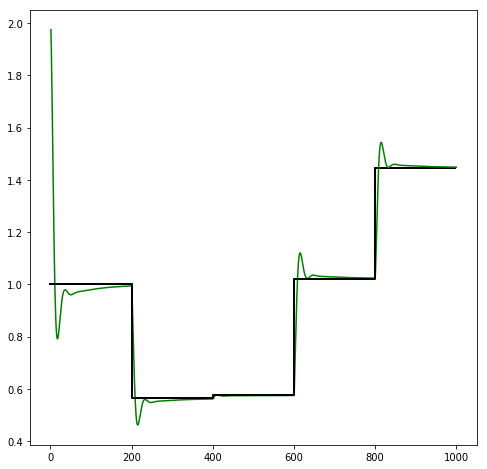

In [132]:
# PID CONTROL of the car following a path!
# Implement a PID controller by running 100 iterations
# of robot motion. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau_p * CTE - tau_d * diff_CTE - tau_i * int_CTE
#
# where the integrated crosstrack error (int_CTE) is
# the sum of all the previous crosstrack errors.
# This term works to cancel out steering drift.
# ------------

robot = Robot()
robot.set(0, 2, 0)
setpoint = - 0.5

max_iteration = 1000
step_change = 200
noise_level = 0.0002
samples = np.arange(0, max_iteration, step_change)
y0 = np.sin(samples)
x_d = y0.copy() * 0.5 + 1
num_samples = np.size(x_d)

def run_PID(robot, tau_p, tau_d, tau_i, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    CTE_prev = 0
    int_CTE = 0
    for r in range(num_samples):
        setpoint = x_d[r]
        for i in range(step_change):
            CTE = robot.y - setpoint 
            diff_CTE = CTE - CTE_prev
            CTE_prev = CTE
            int_CTE += CTE
            steering = -tau_p * CTE - tau_d * diff_CTE - tau_i * int_CTE
            robot.move(steering, speed)
            x_trajectory.append(robot.x)
            y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory 

x_trajectory, y_trajectory = run_PID(robot, 0.7, 4.0, 0.008, step_change)
n = len(x_trajectory)
 
fig, ax1 = plt.subplots(1, 1, figsize=(8,8))
ax1.plot(x_trajectory, y_trajectory, 'g', label='PID controller')
if not num_samples == 1:
    ax1.step(samples, x_d, label='X_d', linewidth = 2, where='post', color = 'black')
    l = ax1.hlines(xmin = 800, xmax = 1000, y = x_d[-1], color = 'black', linewidth=2, zorder=2)
else:
    l = ax1.hline(y = x_d[0], label='X_d', c = 'black', linewidth=2)

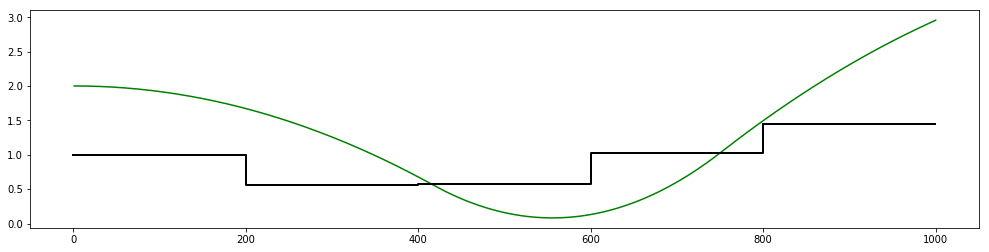

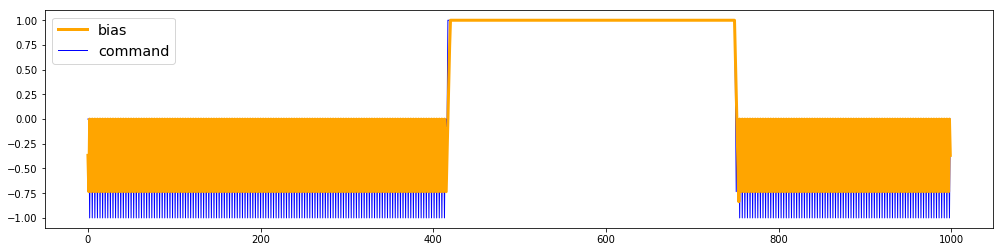

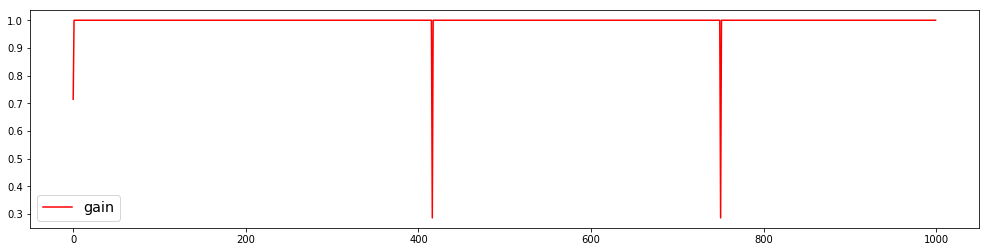

In [133]:
# ABAG implemented for car tracing a path  -> In this case original ABAG cannot work...no breaking and reversing!!!!!
# However ABAG with exteded range of u signal ([-1, 1]) can maybe work if tuned properly!

robot1 = Robot()
robot1.set(0, 2, 0)

max_iteration = 1000
step_change = 200
noise_level = 0.0002
samples = np.arange(0, max_iteration, step_change)
y0 = np.sin(samples)
x_d = y0.copy() * 0.5 + 1
num_samples = np.size(x_d)

abag = ABAG(delta_gain = 0.71436806, 
            delta_bias = 0.36719434, 
            min_gain = 0.000976, 
            alpha = 0.14568438, 
            e_b = 0.46521379, 
            e_g =  0.75446496,
            reverse_error = False,
            area_error = False)

bias = []
gain = []
command = []

def run_ABAG(robot, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    for r in range(num_samples):
        setpoint = x_d[r]
        for i in range(step_change):
            steering = abag.control(robot1.y, setpoint, 0.0)
            bias.append(abag.bias)
            gain.append(abag.gain)
            command.append(steering)
            robot1.move(steering * 0.001, speed)
            x_trajectory.append(robot1.x)
            y_trajectory.append(robot1.y)
    return x_trajectory, y_trajectory 

x_trajectory, y_trajectory = run_ABAG(robot)
n = len(x_trajectory)
 
fig, ax1 = plt.subplots(1, 1, figsize=(17,4))
ax1.plot(x_trajectory, y_trajectory, 'g', label='ABAG controller')

if not num_samples == 1:
    ax1.step(samples, x_d, label='X_d', linewidth = 2, where='post', color = 'black')
    l = ax1.hlines(xmin = 800, xmax = 1000, y = x_d[-1], color = 'black', linewidth=2, zorder=2)
else:
    ax2.hlines(y=x_d[0], xmin=0, xmax = max_iteration, linewidth=2, color='black', label='reference')
    
    
plt.figure(figsize = (17,4))
plt.plot(np.array(bias), c = 'orange', label='bias', linewidth=3, zorder=3)
plt.plot(np.array(command), c = 'blue', label='command', linewidth=1, zorder=2)
plt.legend(loc=2, fontsize = 'x-large')
plt.show()

plt.figure(figsize = (17,4))
plt.plot(np.array(gain), c = 'red', label='gain', linewidth=1.5, zorder=1)
plt.legend(loc=3, fontsize = 'x-large')
plt.show()

In [134]:
#############################################################################################################
# MPC controller for car example only!
# Question is if we need to include noise in the model that is used for predictions, or to go without noise!
# For now model for prediction will be without the noise!
##############################################################################################################

class MPC_CAR:
    def __init__(mpc, position, velocity, plant):
        mpc.position = position
        mpc.velocity = velocity
        mpc.plant = plant
    
    def predict(mpc, abag_params, step_change, trajectory, command_gain, area_size, noise_level):        
        state = [mpc.position, mpc.velocity]
        mpc.abag = ABAG(delta_gain = abag_params[0], 
                        delta_bias = abag_params[1], 
                        min_gain = 0.000976, 
                        alpha = abag_params[2], 
                        e_b = abag_params[3], 
                        e_g = abag_params[4],
                        reverse_error = False,
                        area_error = True)
        final_error = 0
        num_samples = np.size(trajectory)
        for n in range(num_samples):
            for i in range(step_change):
                final_error = final_error + (trajectory[n] - state[0])**2
                u = mpc.abag.control(state[0], trajectory[n], area_size)
#                 if mpc.abag.gain > 0.9:
#                     final_error = final_error + 10000
                mpc.plant.move(u * abag_params[5], state[1])
                state[0] = mpc.plant.y
                
        return final_error

    def control(mpc, y_m, y_d, area_size):
        pass
    
    def optimizer(mpc, init_params, cons, step_change, trajectory, command_gain, area_size, noise_level, opti_method):
        if opti_method is 'trust-constr':
            result = optimize.minimize(mpc.predict, init_params, 
                                       args=(step_change, trajectory, command_gain, area_size, noise_level), 
                                       method='trust-constr', jac= '2-point', constraints=cons, options={'disp': True})
        else:
            result = optimize.minimize(mpc.predict, init_params, 
                                       args=(step_change, trajectory, command_gain, area_size, noise_level), 
                                       method = opti_method, constraints=cons, options={'disp': True})
        print(result.message)
        return result.x

Elements of step function: [1.]
Optimization terminated successfully.
Result: 
[0.54839737 0.08929324 0.00388132 0.07510745 0.9976868  0.19050242]


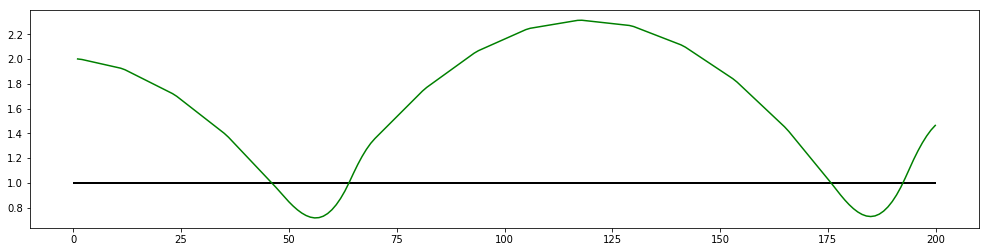

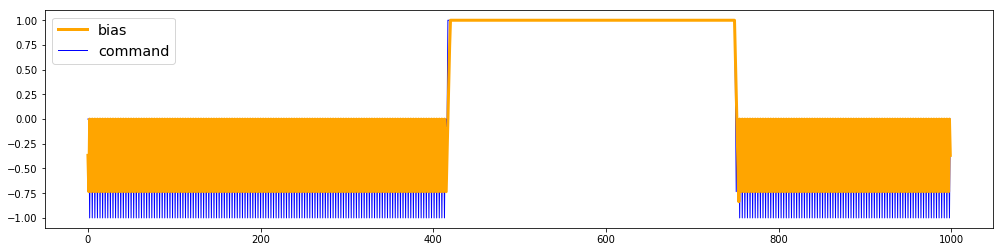

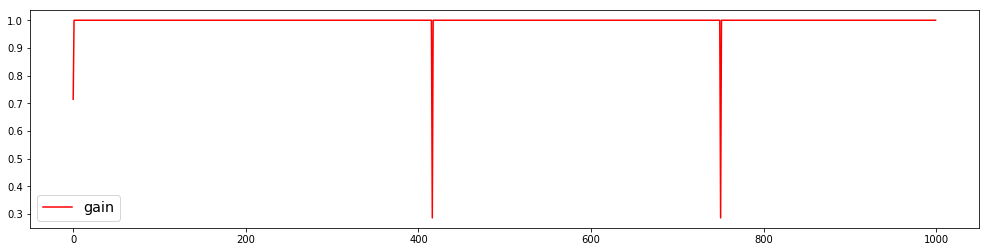

In [141]:
#########################################################################
# Tesing code for ABAG implemented on car tracing a path  -> MPC controller
#  -> In this case original ABAG cannot work...no breaking and reversing!!!!!
# However ABAG with exteded range of u signal ([-1, 1]) can MAYBE work if tuned properly!
#########################################################################


robot = Robot()
initial_y = 2.0
robot.set(0, initial_y, 0)

bounds = (0.000001, 0.999999)

init_parameters = [0.54841309, 0.08921875, 0.00383927, 0.07507396, 0.9976516, 0.19051106]

#construct the bounds in the form of constraints
constraints = []
for factor in range(len(init_parameters)-1):
    lower, upper = bounds
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper, i=factor: ub - x[i]}
    constraints.append(l)
    constraints.append(u)
    
l = {'type': 'ineq',
     'fun': lambda x, lb=0.0, i=factor: x[i] - lb}
constraints.append(l)

max_iteration = 200
step_change = 200
noise_level = 0.0
samples = np.arange(0, max_iteration, step_change)
y0 = np.sin(samples)
x_d = y0.copy() * 0.5 + 1
num_samples = np.size(x_d)
area_size = 0.0

# opti_method  = 'trust-constr'
opti_method  = 'COBYLA'
# opti_method  = 'SLSQP'
print("Elements of step function: " + str(x_d))

mpc_car = MPC_CAR(initial_y, 1.0, robot)
optimized_parameters = mpc_car.optimizer(init_parameters, constraints, 
                                     step_change, x_d, command_gain, 
                                     area_size, noise_level, opti_method)
print("Result: ")
print(optimized_parameters)
command_gain = optimized_parameters[5]

robot = Robot()
initial_y = 2.0
robot.set(0, initial_y, 0)

noise_level = 0.0002
abag = ABAG(delta_gain = optimized_parameters[0], 
            delta_bias = optimized_parameters[1], 
            min_gain = 0.000976, 
            alpha = optimized_parameters[2], 
            e_b = optimized_parameters[3], 
            e_g = optimized_parameters[4],
            reverse_error = False,
            area_error = True)
bias_list = []
gain_list = []
command_list = []

def run_ABAG_MPC(robot, speed=1.0):
    x_ = []
    y_ = []
    for r in range(num_samples):
        setpoint = x_d[r]
        for i in range(step_change):
            steering = abag.control(robot.y, setpoint, 0.0)
            bias_list.append(abag.bias)
            gain_list.append(abag.gain)
            command_list.append(steering)
            robot.move(steering * command_gain, speed)
            x_.append(robot.x)
            y_.append(robot.y)
    return x_, y_

x_traj, y_traj = run_ABAG_MPC(robot)
n = len(x_traj)

fig2, ax2 = plt.subplots(1, 1, figsize=(17,4))
ax2.plot(x_traj, y_traj, 'g', label='ABAG controller - MPC')

if not num_samples == 1:
    ax2.step(samples, x_d, label='X_d', linewidth = 2, where='post', color = 'black')
    l = ax2.hlines(xmin = 800, xmax = 1000, y = x_d[-1], color = 'black', linewidth=2, zorder=2)
else:
    ax2.hlines(y=x_d[0], xmin=0, xmax = max_iteration, linewidth=2, color='black', label='reference')

plt.figure(figsize = (17,4))
plt.plot(np.array(bias), c = 'orange', label='bias', linewidth=3, zorder=3)
plt.plot(np.array(command), c = 'blue', label='command', linewidth=1, zorder=2)
plt.legend(loc=2, fontsize = 'x-large')
plt.show()

plt.figure(figsize = (17,4))
plt.plot(np.array(gain), c = 'red', label='gain', linewidth=1.5, zorder=1)
plt.legend(loc=3, fontsize = 'x-large')
plt.show()